In [ ]:
import numpy as np
import os
import torch
from  models.sae import BatchTopKSAE 
import tqdm
import matplotlib.pyplot as plt
from evaluate_feature import calculate_AUC_matrix

In [30]:
# Define configurations
cfg = {
    "seed": 49,
    "batch_size": 32,
    "lr": 1e-3,
    "l1_coeff": 0,
    "dtype": torch.float32,
    "act_size": 768,
    "dict_size": 768*4,
    "device": "cpu",
    "num_batches_in_buffer": 10,
    "dataset_path": "../data/layer_11_embeddings_30subset.npy",
    "input_unit_norm": True,
    "perf_log_freq": 1000,
    "checkpoint_freq": 10000,
    "n_batches_to_dead": 5,
    "max_grad_norm": 100000,

    # (Batch)TopKSAE specific
    "top_k": 32,
    "top_k_aux": 512,
    "aux_penalty": (1/32),
    # for jumprelu
    "bandwidth": 0.001,
}

In [26]:
# Load data
embeddings = np.load(cfg['dataset_path'])
embeddings.shape

(1972, 1003, 768)

In [27]:
# Initialize the model
model = BatchTopKSAE(cfg=cfg)

In [28]:
# Training loop
num_batches = embeddings.shape[0] // cfg['batch_size']
progress = tqdm.trange(num_batches)
torch.manual_seed(cfg['seed'])
optimizer = torch.optim.Adam(model.parameters(), lr=cfg['lr'])

for i,batch_idx in zip(progress,range(0, len(embeddings), cfg['batch_size'])):
    batch_data = embeddings[batch_idx: batch_idx + cfg['batch_size'],:,:].reshape(-1,768)
    if len(batch_data) < cfg['batch_size']:
        continue  # Skip incomplete batches

    batch_data = torch.tensor(batch_data, dtype=cfg['dtype'], device=cfg['device'])

    sae_output = model(batch_data)
    loss = sae_output['loss']

    optimizer.zero_grad()

    progress.set_postfix({"Loss": f"{loss.item():.4f}", "L0": f"{sae_output['l0_norm']:.4f}", "L2": f"{sae_output['l2_loss']:.4f}", "L1": f"{sae_output['l1_loss']:.4f}", "L1_norm": f"{sae_output['l1_norm']:.4f}"})
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), cfg["max_grad_norm"])
    model.make_decoder_weights_and_grad_unit_norm()
    optimizer.step()



100%|██████████| 61/61 [04:51<00:00,  4.77s/it, Loss=0.2983, L0=32.0000, L2=0.2983, L1=0.0000, L1_norm=73.0146]


In [31]:
batch_size = cfg['batch_size']
top_k = cfg['top_k']
embedding_dim = embeddings.shape[-1]

embeddings = np.load(cfg['dataset_path'], mmap_mode='r')  # memory-map for large files
num_samples = embeddings.shape[0]

all_topk_indices = []
all_topk_values = []

with torch.no_grad():
    for start in tqdm(range(0, num_samples, batch_size)):
        end = min(start + batch_size, num_samples)
        batch = embeddings[start:end]
        if batch.ndim == 3:
            batch = batch.reshape(-1, embedding_dim)
        batch_tensor = torch.tensor(batch, dtype=cfg['dtype'], device=cfg['device'])
        sae_output = model(batch_tensor)
        feature_acts = sae_output["feature_acts"]
        topk_values, topk_indices = torch.topk(feature_acts, top_k, dim=-1)
        all_topk_indices.append(topk_indices.cpu().numpy())
        all_topk_values.append(topk_values.cpu().numpy())

# Concatenate results for all batches
all_topk_indices = np.concatenate(all_topk_indices, axis=0)
all_topk_values = np.concatenate(all_topk_values, axis=0)

In [32]:
# save the results
np.save("../data/topk_indices.npy", all_topk_indices)
np.save("../data/topk_values.npy", all_topk_values)

In [17]:
ground_truth = np.load("../data/chip_exo_57_TF_binding_sites_30subset.npy")
ground_truth_flattened = ground_truth.reshape(-1, 58)[:,57].reshape(-1,1)

In [33]:
auc_matrix = calculate_AUC_matrix(all_topk_values, ground_truth_flattened)

Output()

In [ ]:
auc_matrix.shape

(32, 1)

In [34]:
auc_matrix

array([[0.53898524],
       [0.53165955],
       [0.52521494],
       [0.52031133],
       [0.5180403 ],
       [0.51594066],
       [0.51512815],
       [0.51575421],
       [0.5180967 ],
       [0.52266517],
       [0.52667545],
       [0.52969535],
       [0.53343067],
       [0.53981264],
       [0.54576522],
       [0.55219897],
       [0.55955527],
       [0.56711576],
       [0.57442811],
       [0.58168398],
       [0.58876178],
       [0.59558096],
       [0.6011477 ],
       [0.60792922],
       [0.61250833],
       [0.61699443],
       [0.62032367],
       [0.62365578],
       [0.6249882 ],
       [0.62657838],
       [0.62523087],
       [0.62323472]])

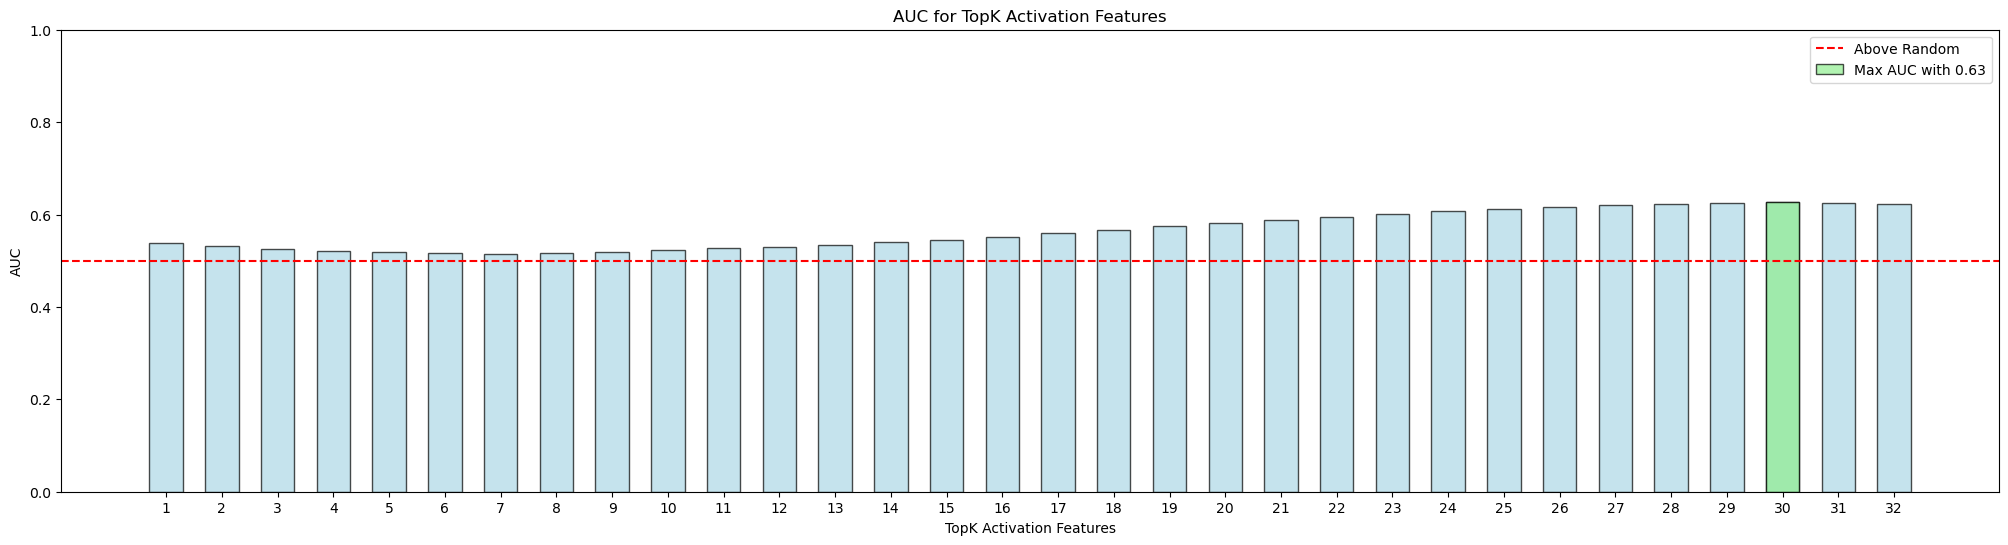

In [35]:
# Plot Bar for AUC of each PC
plt.figure(figsize=(25, 6))
plt.style.use('seaborn-v0_8-deep')
plt.bar(range(1, auc_matrix.shape[0] + 1), auc_matrix.flatten(), color='lightblue', edgecolor='black', width=0.6, alpha=0.7)
plt.axhline(y=0.5, color='red', linestyle='--', label='Above Random')
plt.xlabel('TopK Activation Features')
plt.ylabel('AUC')
plt.title('AUC for TopK Activation Features')

plt.ylim(0, 1)
plt.xticks(range(1, 33))
# color the bar with higer AUC in green
max_auc = np.max(auc_matrix)
max_auc_index = np.argmax(auc_matrix)
plt.bar(max_auc_index + 1, auc_matrix.flatten()[max_auc_index], color='lightgreen', edgecolor='black', width=0.6, alpha=0.7, label=f'Max AUC with {max_auc:.2f}')
plt.legend()